In [ ]:
import tweepy
import webbrowser
from tweepy import Stream
from tweepy.streaming import StreamListener
from tweepy import Cursor
from tweepy import API
import pandas as pd
import numpy as np
import re
from textblob import Word, TextBlob
import nltk
import matplotlib.pyplot as plt
import json
# from wordcloud import WordCloud

In [ ]:
# We shall be analysing tweets with respect to presidential debate

with open('manager.json') as f:
    data = json.load(f)
    consumer_key = data['API_key']
    consumer_secret = data['API_secret_Key']
    Bearer_Token = data['Bearer_Token']


callback_url= 'oob'
auth= tweepy.OAuthHandler(consumer_key,consumer_secret,callback_url) # Authenticate our User
redirect_url = auth.get_authorization_url() # Get URL to direct user
# print(redirect_url)
webbrowser.open(redirect_url)
user_pint_input = input ("What's the pin value? ")
user_pint_input
auth.get_access_token(user_pint_input)
api= tweepy.API(auth, wait_on_rate_limit=True)
me = api.me()

In [ ]:
# Setting up tweeter handler

hashtag = '#covid-19'
query = tweepy.Cursor(api.search, q=hashtag,lang='en').items(200)  # The search method will help us search
# print(dir(query)) 
tweets = [ {'Tweets':tweet.text, 'Timestamp':tweet.created_at} for tweet in query]
# print(tweets)

In [ ]:
# Import tweets into a data frame
# convert dictionary to list
tweets = list(tweets) 
df = pd.DataFrame(tweets, columns=['Tweets','Timestamp'])
print(df)

In [ ]:

# Cleaning tweets
def clean_text(raw_text):
    raw_text = re.sub(r'@[A-Za-z0-9]+','',raw_text) # Remove all @mentions and numbers
    raw_text = re.sub(r'#','',raw_text) # Remove the # symbol
    raw_text = re.sub(r'RT[\s]+','',raw_text) # Removing the RT
    raw_text = re.sub(r'https?:\/\/\S+','',raw_text) # Remove hyper links
    raw_text = re.sub(r':','',raw_text)
    raw_text = re.sub(r'_','',raw_text)
    raw_text = re.sub(r'\n\n','',raw_text)
    raw_text = re.sub(r'--&','',raw_text)
    raw_text = re.sub(r'\n','',raw_text)
    return raw_text

df['Tweets'] = df['Tweets'].apply(clean_text)

# print(df)
# print(df.shape)

In [ ]:
# Remove emorjis
def removeEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

df['Tweets'] = df['Tweets'].apply(removeEmojify)

# print(df)

In [ ]:
# Subjectivity and the polarity

# How much a piece of text is based on emotion or how objective or subjective it is ranging from 0 to 1
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# How positive or negative something is ranging from -1 to 1
def getPolarity(text): 
    return TextBlob(text).sentiment.polarity

df['Subjectivity'] = df['Tweets'].apply(getSubjectivity)
df['Polarity'] = df['Tweets'].apply(getPolarity)

# print(df)

In [ ]:
# Create a new function to compute negative, neutral and positive analysis

def getAnalysys(score):
        if score<0:
            return -1
        elif score == 0:
            return 0
        else:
            return 1

df['Analysis'] = df['Polarity'].apply(getAnalysys)
# print(df)

In [ ]:
print(df)

In [ ]:
# Virtualize the frequent words
# Plot the word cloud
# allword = ' '.join([twts for twts in df['Tweets']]) # Put all words in a single string
# allword = ' '.join([twts for twts in df['Tweets'][df=['Analysis']==0]]) # Positive == 0 and Negative == 1
# wordCloud = WordCloud(width = 500, height = 300, random_state = 21, max_font_size = 119).generate(allword)
# plt.imshow(wordCloud, interpolation='bilinear')
# plt.axis('off')
# plt.show()

In [ ]:
X = df.iloc[:, :-1].values # : means the range and -1 means less the last column
Y = df.iloc[:,-1].values
# print(x)
#print(y)

In [ ]:
# Encoding the independent variables

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

ct = ColumnTransformer(transformers=[('encoder',OneHotEncoder(),[0,1])],remainder='passthrough') # Pass through will not encode the other columns. [3] represents index to encode
X = ct.fit_transform(X).toarray()
print(X)

In [ ]:
# Splitting data into Training and Test set
# We need to train data so as to avoid over fitting and under fitting
# We want the results of our Training and Test data to match
# random_state controls the shuffling applied to the data before applying the split
# test_size should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split.
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=1)

In [ ]:
# Trainig the multi Linear regresion model on the training set
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,max_error,explained_variance_score

regressor = LinearRegression()
regressor.fit(x_train,y_train)

In [ ]:
pred = regressor.predict(x_test)
np.set_printoptions(precision=2)
joinedArrays = np.concatenate((pred.reshape(len(pred),1),y_test.reshape(len(y_test),1)),1) # Just 1 column. 0 = vertical axis and 1 = horizontal axis

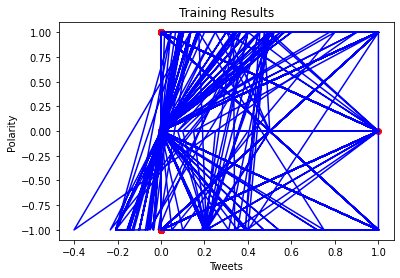

In [212]:
# Visualising training results

plt.scatter(x_train[:,0],y_train, color = 'red')
plt.plot(x_train,regressor.predict(x_train),color = 'blue')
plt.title('Training Results')
plt.xlabel('Tweets')
plt.ylabel('Polarity')
plt.show() 

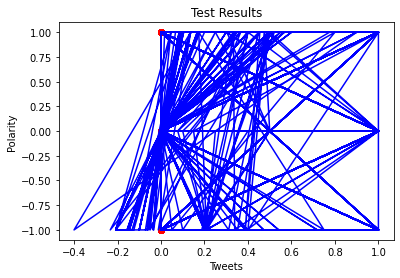

In [213]:
# Visualising test results

plt.scatter(x_test[:,0],y_test, color = 'red')
plt.plot(x_train,regressor.predict(x_train),color = 'blue')
plt.title('Test Results')
plt.xlabel('Tweets')
plt.ylabel('Polarity')
plt.show()

In [214]:
from sklearn import linear_model

ols = linear_model.LinearRegression()
model = ols.fit(X, Y)
model.coef_ # The linear regression coefficient can be accessed in a form of class attribute with model.coef_
model.intercept_ # The y-intercept can be accessed in a form of class attribute with model.intercept_
model.score(X, Y) # How good was your model? You can evaluate your model performance in a form of R-squared, with model.score(X, y). X is the features, and y is the response variable used to fit the model.

1.0